In [ ]:
!python -m spacy download fr_core_news_md

In [ ]:
!pip install unidecode

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
import spacy
from unidecode import unidecode

In [4]:
dff = pd.read_parquet("flue-train.parquet")

In [5]:
text = dff['text'][0]
len(text.split())

992

In [6]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5997 entries, 0 to 5996
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5997 non-null   object
 1   label   5997 non-null   int64 
 2   idx     5997 non-null   int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 117.3+ KB


In [7]:
print(sum(dff['label']==0))
print(sum(dff['label']==1))

3000
2997


In [8]:
def calculer_longeur(text):
  return len(text.split())

In [9]:
dff = dff.assign(longueur_texte=dff['text'].apply(calculer_longeur))

In [10]:
dff.drop(columns='idx', inplace = True)

In [11]:
dff.describe()

,label,longueur_texte
count,5997.000000,5997.000000
mean,0.499750,103.130399
std,0.500042,92.695546
min,0.000000,2.000000
25%,0.000000,45.000000
50%,0.000000,78.000000
75%,1.000000,126.000000
max,1.000000,1026.000000


In [12]:
df = pd.read_parquet("flue-test.parquet")

In [13]:
df.head()

,text,label,idx
0,Alors que les premiers X-men avaient l'affecti...,0,1
1,on attendait bien plus sur cette génèse; les e...,0,2
2,"Une histoire qui s'éloigne du livre, des scène...",0,3
3,"Wolverine est de retour, sans les X-Men et por...",0,4
4,"Grand fan de la période ""épisodes courts et dr...",0,5


In [14]:
df.drop(columns='idx', inplace = True)

In [15]:
df = df.assign(longueur_texte=df['text'].apply(calculer_longeur))

In [16]:
df.describe()

,label,longueur_texte
count,5999.000000,5999.000000
mean,0.499917,103.180030
std,0.500042,94.575524
min,0.000000,1.000000
25%,0.000000,46.000000
50%,0.000000,78.000000
75%,1.000000,127.000000
max,1.000000,1261.000000


In [17]:
df2 = df[df['longueur_texte']<104]

In [18]:
df2.head(10)

,text,label,longueur_texte
0,Alors que les premiers X-men avaient l'affecti...,0,67
1,on attendait bien plus sur cette génèse; les e...,0,65
2,"Une histoire qui s'éloigne du livre, des scène...",0,73
4,"Grand fan de la période ""épisodes courts et dr...",0,103
5,VRAIMENT PAS CONTENT Le son n est pas du tout ...,0,78
6,C'est un réel plaisir de replonger dans cette ...,1,54
7,"J'ai trouvé ce film très moyen. Un ersatz de ""...",0,32
8,ILS EN ONT FAIT DE LA PUBLICITE AUTOUR DE CE F...,0,52
9,"Dans la lignée de ""Full Monty"", ""My name is Jo...",1,96
13,"Bon, comme d'habitude, c'est génial ! Drôle, r...",1,60


In [19]:
df = pd.concat([dff, df], axis=0)

In [20]:
df.shape

(11996, 3)

In [21]:
dff.shape

(5997, 3)

In [22]:
df.drop( columns = "longueur_texte", inplace = True )

In [23]:
dff = pd.read_csv("FR-tweets-sentiment.csv",encoding='latin1')

In [24]:
dff.shape

(62867, 6)

In [25]:
dff.drop(columns=['language', 'tweet_id', 'tweet_date_created','sentiment_score'], inplace = True)

In [26]:
dff.drop(dff[dff['sentiment']=="MIXED"].index, inplace = True)

In [27]:
dff.rename(columns={'tweet_text':'text' , 'sentiment':'label'},inplace=True)
dff['label'].replace(['NEUTRAL' , 'POSITIVE' , 'NEGATIVE' ], [0,1,-1] , inplace= True)

In [28]:
class_1_samples = dff[dff['label'] == 1].sample(n=10000, replace=True, random_state=42)
class_0_samples = dff[dff['label'] == 0].sample(n=6000, replace=True, random_state=42)
class_n_samples = dff[dff['label'] == -1].sample(n=1962, replace=True, random_state=42)

In [29]:
dff = pd.concat([class_1_samples , class_0_samples , class_n_samples] , keys = ['Positive' , 'Neutre' ,'Negative'] , names = ['class'])

In [30]:
class_1_samples.drop(class_1_samples.index, inplace=True)
class_0_samples.drop(class_0_samples.index, inplace=True)
class_n_samples.drop(class_n_samples.index, inplace=True)

In [31]:
dff.shape

(17962, 2)

In [32]:
file_path = "dataset_gpt.npy"
list_samples = np.load(file_path)

In [33]:
df2 = pd.DataFrame(list_samples, columns=["text", "label"])
# dff = dff.append(df2, ignore_index=True)
dff = pd.concat([dff, df2], axis=0)

In [34]:
dff.shape

(18293, 2)

In [35]:
dff = pd.concat([dff, df], axis=0)

In [36]:
dff.shape

(30289, 2)

In [37]:
df2.drop(df2.index, inplace=True)

In [38]:
df.drop(df.index, inplace=True)

In [39]:
dff.tail(10)

,text,label
5989,J'ai du lire ce livre pour un exposé sur le pr...,0
5990,Ce livre est un jolie copier/coller en concent...,0
5991,"Expatrié depuis près de 3 ans, j'avais beaucou...",1
5992,Un ouvrage qui permet d'éviter des étymologies...,1
5993,"Les films sont splendides, mais le livre est c...",1
5994,"On m'avait dit 'Tu verras, c'est génial, y'a p...",0
5995,"''Et après'' est un roman qui se lit bien, mal...",1
5996,j'ai decouvert grace a ce livre ce qui me manq...,1
5997,"On peut y trouver un peu du Joueur, un peu du ...",1
5998,L'histoire n'est pas trop mal pour ceux qui ai...,0


In [40]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
STOP_WORDS =list(fr_stop)

In [41]:
STOP_WORDS.remove('pas')
STOP_WORDS.remove('ne')
STOP_WORDS.remove('n\'')
my_stop_words = ['j', 'm', 'd' , 't' , 'l' , 'c', 'jai', 'qu', 'tamwilcom', 'tamwilkom', '@',
                 'football', 'putain', 'film' , 'livre', 'prediction', 'séries', 'séerie', 'films' , 'livres',
                 "joueur" , "joueurs", 'arsenal', 'album', 'saison', 'club','match', 'clubs', 'matchs', 'groupe', 'histoire', 'fan', 'merde',
                 'city']
STOP_WORDS = STOP_WORDS + my_stop_words

In [42]:
def clean_STOP_WORDS(text):
  "remove chars that are not letters or numbers, downcase, then remove stop words"
  regex = re.compile("([^\s\w])+")
  sentence = regex.sub(' ', text).lower()
  sentence = sentence.split()
  for word in list(sentence):
    if word in STOP_WORDS:
      sentence.remove(word)
  sentence = " ".join(sentence)
  return sentence

In [43]:
dff["text"] = dff["text"].apply(clean_STOP_WORDS)

In [44]:
dff.tail(10)

,text,label
5989,lire exposé progrès,0
5990,jolie copier coller concentré cour bts audiovi...,0
5991,expatrié 3 ans beaucoup mal pas trop temps com...,1
5992,ouvrage éviter étymologies fondées analogies s...,1
5993,splendides carrement magique oeuvre grandiose ...,1
5994,verras génial pas mieux trompés essayé lire ac...,0
5995,roman lit bien faut tourner pages arriver vif ...,1
5996,decouvert grace manqué evoluer grace manqué te...,1
5997,trouver désert tartares prince propre expérien...,1
5998,n pas trop mal aiment genre style abominable p...,0


In [45]:
# Charger le modèle spaCy en français (la version moyenne)
nlp = spacy.load("fr_core_news_md")

In [46]:
def lemmatisation(text):
    # Analyser le texte avec le modèle SpaCy
    doc = nlp(text)
    # Créer une liste de lemmes pour chaque token dans le document
    lemmas = [unidecode(token.lemma_ )for token in doc]
    # Joindre les lemmes pour former un nouveau texte lemmatisé
    new_text = " ".join(lemmas)
    # Retourner le nouveau texte lemmatisé
    return new_text


In [47]:
dff["text"] = dff["text"].apply(lemmatisation)

In [48]:
dff.tail(10)

,text,label
5989,lire expose progres,0
5990,joli copier coller concentrer cour bts audiovi...,0
5991,expatrie 3 an beaucoup mal pas trop temps comp...,1
5992,ouvrage eviter etymologie fonder analogie supe...,1
5993,splendide carrement magique oeuvre grandiose b...,1
5994,voir genial pas mieux tromper essayer lire act...,0
5995,roman lit bien falloir tourner page arriver vi...,1
5996,decouvert grac manquer evoluer grace manquer t...,1
5997,trouver desert tartare prince propre experienc...,1
5998,n pas trop mal aimer genre style abominable pa...,0


In [49]:
# Load the French word list (replace with your actual word list)
with open("french_word_list.txt", "r", encoding="utf-8") as f:
    french_word_list = set(word.strip() for word in f)

# Function to clean text by filtering based on the French word list
def clean_OOV(text):
    # Tokenize the text
    tokens = text.split()

    # Filter out words not in the French word list
    cleaned_tokens = [token for token in tokens if token in french_word_list]

    # Join the cleaned tokens to form a cleaned text
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [50]:
# Apply the cleaning function to the 'text' column of dff
dff["text"] = dff["text"].apply(clean_OOV)

In [51]:
dff.tail(10)

,text,label
5989,lire expose progres,0
5990,joli copier coller concentrer cour audiovisuel...,0
5991,expatrie an beaucoup mal pas trop temps compre...,1
5992,ouvrage eviter fonder analogie superficiel aid...,1
5993,splendide carrement magique oeuvre grandiose b...,1
5994,voir genial pas mieux tromper essayer lire act...,0
5995,roman lit bien falloir tourner page arriver vi...,1
5996,decouvert manquer evoluer grace manquer techni...,1
5997,trouver desert prince propre experience moment...,1
5998,pas trop mal aimer genre style passage acciden...,0


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# get individual words
words = []
for line in dff['text']:
 words.extend(line)

# create a word frequency dictionary
wordfreq = Counter(words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
 background_color=’white’,
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation=’bilinear’)
plt.axis(“off”)
plt.show()

In [1]:
# Save DataFrame using pickle format
dff.to_pickle("FSA_dataset.pkl")

NameError: ignored

In [54]:
dff.shape

(30289, 2)

In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load DataFrame from pickle format
dff = pd.read_pickle("FSA_dataset.pkl")

In [5]:
dff.shape

(30289, 2)

In [6]:
X = dff['text']
Y = dff['label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
dff.drop(dff.index, inplace=True)

In [8]:
# Créez une instance du vecteur TF-IDF / CountVectorizer
vectorizer = CountVectorizer()
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
# Ajustez et transformez les données d'entraînement
X_train = vectorizer.fit_transform(X_train)
X_train = transformer.fit_transform(X_train)

# Transformez les données de test
X_test = vectorizer.transform(X_test)
X_test = transformer.transform(X_test)

In [9]:
print(X_train.shape)
print(X_test.shape)

(24231, 10258)
(6058, 10258)


In [10]:
X.drop(X.index, inplace=True)

In [11]:
X_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

In [13]:
y_test = y_test.astype(int)
y_train = y_train.astype(int)

In [14]:
RFC = RandomForestClassifier( n_estimators = 200 , max_depth = None )
RFC.fit(X_train , y_train)

RandomForestClassifier(n_estimators=200)

In [15]:
y_pred = RFC.predict(X_test)
print(classification_report(y_pred , y_test))

              precision    recall  f1-score   support

          -1       0.62      0.95      0.75       285
           0       0.78      0.78      0.78      2352
           1       0.88      0.83      0.86      3421

    accuracy                           0.82      6058
   macro avg       0.76      0.85      0.80      6058
weighted avg       0.83      0.82      0.82      6058



In [ ]:
y_train.shape

(24231,)

In [ ]:
# ros = RandomOverSampler()
# X_tain , y_train = ros.fit_resample(X_train.values , y_train)

In [14]:
# Apply SMOTE to both features and target
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
X_train.shape

(38442, 10235)

In [16]:
print(sum(y_train==1))
print(sum(y_train==0))
print(sum(y_train==-1))

12814
12814
12814


In [17]:
RFC2 = RandomForestClassifier( n_estimators = 100 , max_depth = None )
RFC2.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
y_pred = RFC2.predict(X_test)
print(classification_report(y_pred , y_test))

              precision    recall  f1-score   support

          -1       0.69      0.46      0.55       627
           0       0.75      0.74      0.74      2424
           1       0.81      0.87      0.84      3007

    accuracy                           0.78      6058
   macro avg       0.75      0.69      0.71      6058
weighted avg       0.77      0.78      0.77      6058



In [23]:
import pickle
# Save the model to a file using pickle
with open('fr_model_v3.pkl', 'wb') as file:
    pickle.dump(RFC, file)

In [ ]:
# Save the model to a file using pickle
with open('fr_model_v3.pkl', 'rb') as file:
    model = pickle.load(file)

In [24]:
with open("fr_featuresNames_v3.txt", "wb") as fp:
  pickle.dump(vectorizer.get_feature_names_out(), fp)

#Visual representation of a decision tree from a RandomForestClassifier

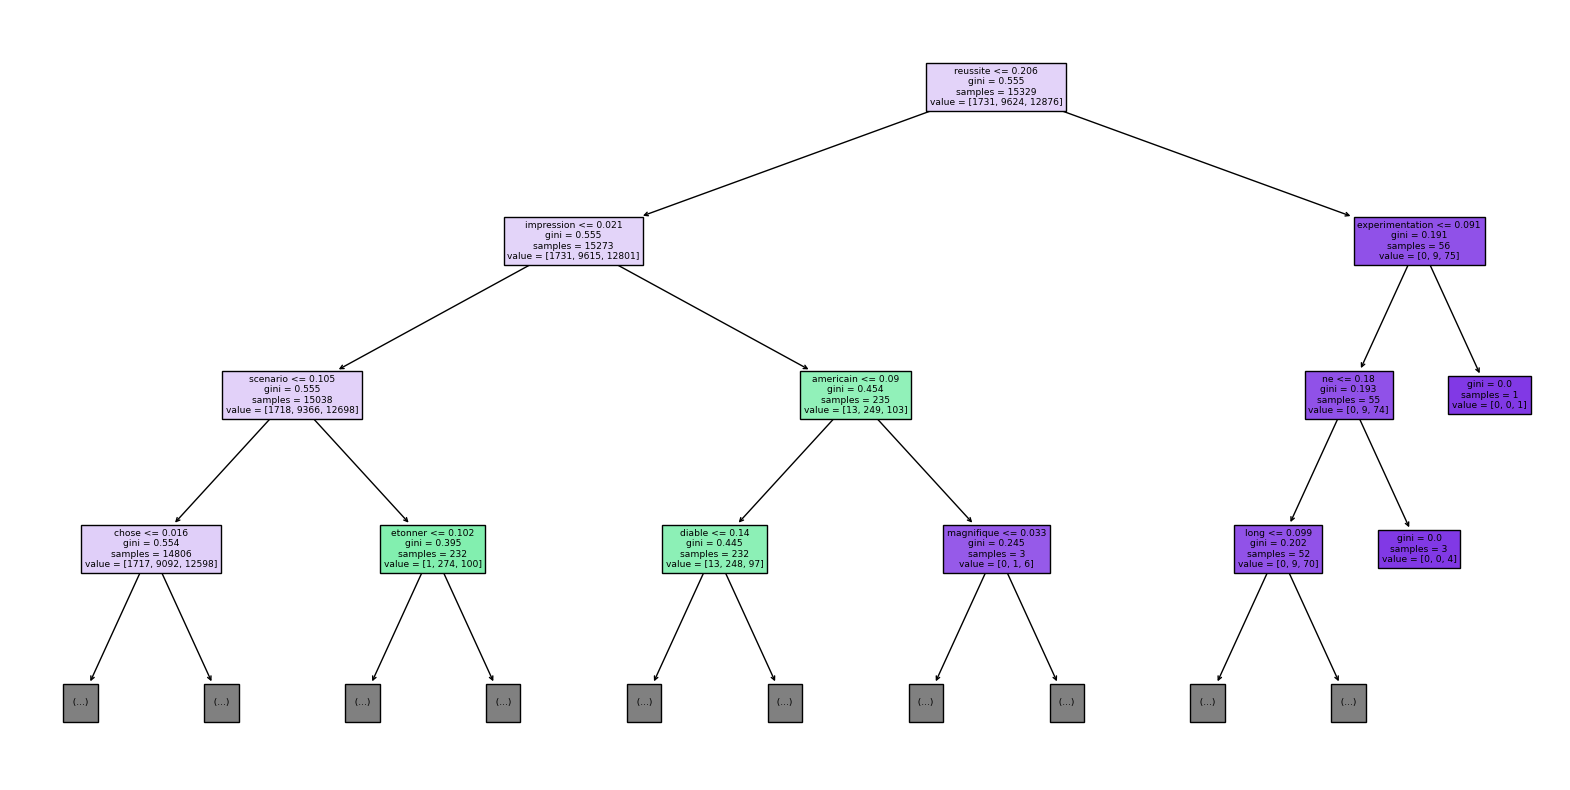

In [28]:
plt.figure(figsize=(20, 10))
plot_tree(RFC.estimators_[4], filled=True, feature_names=X_train.columns, max_depth=3)  # Adjust max_depth as needed
plt.show()

#Chaque arbre de décision dans la forêt attribue des poids aux caractéristiques en fonction de leur contribution à la séparation des classes.

In [ ]:
feature_importances = RFC.feature_importances_
print("Importance des caractéristiques:\n", feature_importances[0:10]) # juste les 11 premiers

Importance des caractéristiques:
 [6.70576774e-05 6.19724135e-06 6.55792638e-05 3.23543542e-08
 3.86889960e-05 2.19803818e-04 0.00000000e+00 4.07305685e-07
 4.85721002e-04 4.09746142e-06]


#Visualisation de l'importance des 10 meilleures caractéristiques (features) dans le modèle RandomForestClassifier.

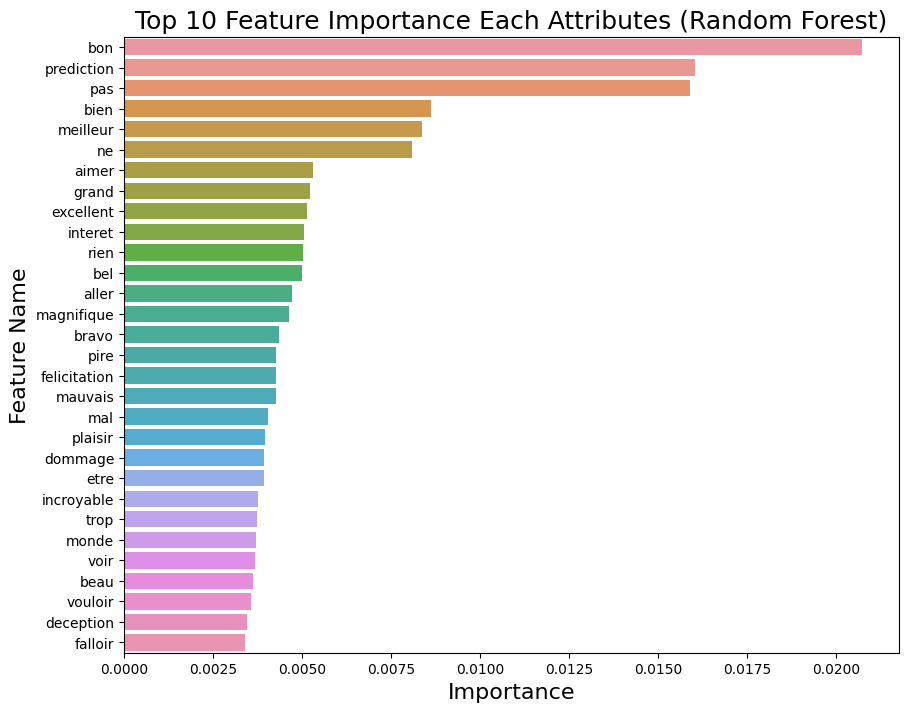

In [29]:
imp_df = pd.DataFrame({
"Feature Name" : X_train.columns,
"Importance": RFC.feature_importances_
})
fi = imp_df.sort_values (by="Importance", ascending=False)
fi2 =  fi.head(30)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

In [19]:
fi['Feature Name'][19:50]

7400        plaisir
3227        dommage
3898           etre
5214     incroyable
9842           trop
6463          monde
10182          voir
1067           beau
10210       vouloir
2645      deception
4110        falloir
2649       decevoir
10220      vraiment
6357          mieux
838           aucun
3823        esperer
2648       decevant
4917        heureux
6692            non
7100         passer
2710           decu
1068       beaucoup
2298         contre
3786         equipe
9857        trouver
927           avoir
7652        prendre
9330          super
5615         jamais
5657          jouer
7044        parfait
Name: Feature Name, dtype: object

In [21]:
'the' in X_train.columns

True